In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold,SelectPercentile
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier, StackingClassifier
from sklearn.naive_bayes import ComplementNB, BernoulliNB, GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,  QuadraticDiscriminantAnalysis
%pip install catboost
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier

# 데이터 경로와 시드값

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATA_PATH = "/content/drive/MyDrive/멋쟁이사자차럼/data/"
SEED = 42

# 데이터 불러오기

In [35]:
import pandas as pd
import numpy as np


train_tr = pd.read_csv(f"{DATA_PATH}store_train_transactions.csv") # 학습용 구매기록 데이터
train_target = pd.read_csv(f"{DATA_PATH}store_train.csv") # 학습용 정답 데이터
test_tr = pd.read_csv(f"{DATA_PATH}store_test_transactions.csv") # 테스트용 구매기록 데이터
submit = pd.read_csv(f"{DATA_PATH}store_submission.csv") # 제출 양식 데이터

train_ft = pd.read_csv(f"{DATA_PATH}train_ft2.csv")
test_ft = pd.read_csv(f"{DATA_PATH}test_ft2.csv")
train_ft.shape ,test_ft.shape

((14940, 367), (12225, 367))

# 피처 추가

In [36]:
# 상수 특성 제거
train_ft.drop(columns=['야채생선_x_인스턴트구매_O'], inplace=True, errors='ignore')
test_ft.drop(columns=['야채생선_x_인스턴트구매_O'], inplace=True, errors='ignore')

In [37]:
# def create_weekend_evening_features(tr_data):
#     """
#     주말(토요일, 일요일) 오후 6시 이후에 특정 품목을 구매한 횟수를 계산하여 피처를 생성합니다.

#     Parameters:
#     tr_data (DataFrame): 구매 기록이 포함된 데이터프레임 (train_tr 또는 test_tr).

#     Returns:
#     DataFrame: 각 고객(ID)별 주말 저녁 특정 품목 구매 횟수를 포함한 새로운 피처.
#     """
#     # 1. '구매일시'를 기준으로 요일과 시간을 추출합니다.
#     tr_data['요일'] = tr_data['구매일시'].dt.weekday
#     tr_data['시간'] = tr_data['구매일시'].dt.hour

#     # 2. 주말(토요일: 5, 일요일: 6) 및 오후 6시 이후(18시 이후) 데이터 필터링
#     weekend_evening_data = tr_data[(tr_data['요일'] >= 5) & (tr_data['시간'] >= 18)]

#     # 3. '중분류'가 특정 품목에 해당하는 경우만 필터링
#     target_categories = ['수입종합화장품', '란제리', '유아복', '수입의류']
#     filtered_data = weekend_evening_data[weekend_evening_data['중분류'].isin(target_categories)]

#     # 4. 고객별(ID)로 특정 품목 구매 횟수를 집계
#     purchase_count = filtered_data.groupby('ID').size().reset_index()
#     purchase_count.columns = ['ID', 'weekend_evening_purchase_count']  # 새로운 피처 이름 지정

#     return purchase_count

# # === Train 데이터에서 새로운 피처 생성 ===
# train_weekend_evening_features = create_weekend_evening_features(train_tr)

# # Train 데이터에 병합
# train_ft = train_ft.merge(train_weekend_evening_features, how='left', on='ID').fillna(0)

# # === Test 데이터에서 새로운 피처 생성 ===
# test_weekend_evening_features = create_weekend_evening_features(test_tr)

# # Test 데이터에 병합
# test_ft = test_ft.merge(test_weekend_evening_features, how='left', on='ID').fillna(0)


# 항상확인하기

In [38]:
# 피처 이름의 공백을 밑줄로 대체
train_ft.columns = train_ft.columns.str.replace(' ', '_')
test_ft.columns = test_ft.columns.str.replace(' ', '_')

In [39]:
train_ft.shape, test_ft.shape

((14940, 366), (12225, 366))

# 결측치 처리

In [40]:
train_ft.isnull().sum()
test_ft.isnull().sum()
train_ft = train_ft.fillna(0)
test_ft = test_ft.fillna(0)

train_ft.isnull().sum().sum(), test_ft.isnull().sum().sum()

(0, 0)

In [41]:
# display(train_ft.isnull().sum())
# display(test_ft.isnull().sum())

In [42]:
# e_level = train_ft["고객_교육수준"].mode()[0]
# m_status = train_ft["고객_결혼여부"].mode()[0]
# s_mean = train_ft["고객_소득"].mean()

# e_level, m_status, s_mean

In [43]:
# train_ft["고객_교육수준"] = train_ft["고객_교육수준"].fillna(e_level)
# train_ft["고객_결혼여부"] = train_ft["고객_결혼여부"].fillna(m_status)
# train_ft["고객_소득"] = train_ft["고객_소득"].fillna(s_mean)

# test_ft["고객_교육수준"] = test_ft["고객_교육수준"].fillna(e_level)
# test_ft["고객_결혼여부"] = test_ft["고객_결혼여부"].fillna(m_status)
# test_ft["고객_소득"] = test_ft["고객_소득"].fillna(s_mean)

# train_ft.isnull().sum().sum(), test_ft.isnull().sum().sum()

# 피처 인코딩

In [44]:
# ID 컬럼 제거
train_ft = train_ft.drop(columns="ID")
test_ft = test_ft.drop(columns="ID")
cols = train_ft.select_dtypes("object").columns.tolist()
cols


from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown="ignore")
tmp = pd.DataFrame(
    enc.fit_transform(train_ft[cols]).toarray(),
    columns =  enc.get_feature_names_out()
)

train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)
train_ft.head()
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)
test_ft.head()

,내점일수,구매주기,주말방문비율,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,주구매요일,일별평균구매건수,거래개월수,...,주구매_대분류_여성캐주얼,주구매_대분류_여성캐쥬얼,주구매_대분류_영라이브,주구매_대분류_영어덜트캐쥬얼,주구매_대분류_영캐릭터,주구매_대분류_영플라자,주구매_대분류_잡화,주구매_대분류_잡화파트,주구매_대분류_케주얼_구두_아동,주구매_대분류_패션잡화
0,7,32,0.571429,0.285714,0.285714,0.428571,0.000000,1,1.400000,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,54,0.250000,0.000000,0.000000,0.750000,0.250000,0,1.333333,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,8,0.000000,0.000000,0.600000,0.400000,0.000000,0,2.500000,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,28,16,0.031250,0.062500,0.468750,0.343750,0.125000,3,2.000000,7,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,19,29,0.476190,0.380952,0.285714,0.238095,0.095238,6,2.333333,4,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 피처 스케일링

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
scaler = StandardScaler()
scaler.fit(train_ft)

StandardScaler()

In [47]:
train_ft[train_ft.columns] = scaler.transform(train_ft)
test_ft[test_ft.columns] = scaler.transform(test_ft)
target = train_target["target"]
target.mean()

0.3931726907630522

# 모델 들

### 로지스틱

  0%|          | 0/100 [00:00<?, ?it/s]

최적의 Percentile: 51.0, 최고 F1 Macro 점수: 0.7149


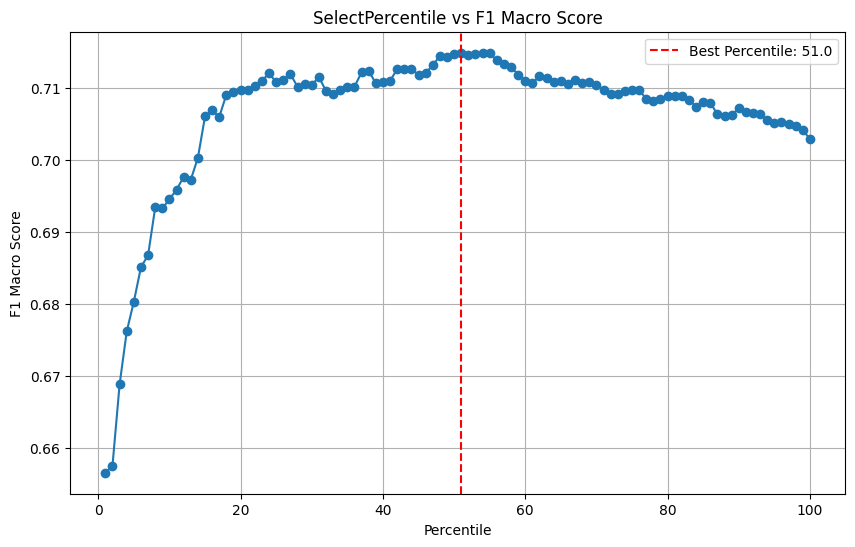

In [ ]:
# 평가 지표 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LogisticRegression(random_state=42)

# 결과 저장 리스트 초기화
scores = []

# SelectPercentile을 사용하여 최적의 percentile 찾기
for percentile in tqdm(range(1, 101)):
    # SelectPercentile 설정 및 피처 선택
    sp = SelectPercentile(percentile=percentile)
    x = sp.fit_transform(train_ft, target)

    # 교차 검증을 통해 F1 Macro 점수 계산
    score = cross_val_score(model, x, target, cv=cv, scoring="f1_macro", n_jobs=-1).mean()

    # 결과 저장
    scores.append([percentile, score])

# numpy 배열로 변환
scores = np.array(scores)

# 최적의 percentile 찾기
idx = np.argmax(scores[:, 1])
best_percentile, best_score = scores[idx]
print(f"최적의 Percentile: {best_percentile}, 최고 F1 Macro 점수: {best_score:.4f}")

# 성능 변화 그래프 시각화
plt.figure(figsize=(10, 6))
plt.plot(scores[:, 0], scores[:, 1], marker='o')
plt.axvline(x=best_percentile, color='r', linestyle='--', label=f'Best Percentile: {best_percentile}')
plt.xlabel('Percentile')
plt.ylabel('F1 Macro Score')
plt.title('SelectPercentile vs F1 Macro Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 최적의 Percentile 값 적용
sp = SelectPercentile(percentile=51)
train_ft_selected = sp.fit_transform(train_ft, target)

# Logistic Regression 모델 정의
model_logreg = LogisticRegression(random_state=42)

# 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# F1 Macro 점수 계산
logreg_scores = cross_val_score(model_logreg, train_ft_selected, target, cv=cv, scoring="f1_macro", n_jobs=-1)
print("Logistic Regression 평균 F1 Macro 점수:", logreg_scores.mean())

Logistic Regression 평균 F1 Macro 점수: 0.7148865777118446


### SGDClassifier(튜닝필수)

In [ ]:
# model = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)   # 0.6624478279967579 25초

In [ ]:
# 4분
# 최적의 하이퍼파라미터: {'penalty': 'l2', 'learning_rate': 'invscaling', 'eta0': 0.001, 'alpha': 0.01}
# 최적의 F1 Macro Score: 0.7097009322225061

param_dist = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.001, 0.01, 0.1],  # 초기 학습률
    'penalty': ['l2', 'l1', 'elasticnet']
}

model = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=5,
    random_state=42
)
random_search.fit(train_ft, target)
print("최적의 하이퍼파라미터:", random_search.best_params_)
print("최적의 F1 Macro Score:", random_search.best_score_)

### Linear Discriminant Analysis (LDA)

  0%|          | 0/100 [00:00<?, ?it/s]

최적의 Percentile: 51.0, 최고 F1 Macro 점수: 0.7117


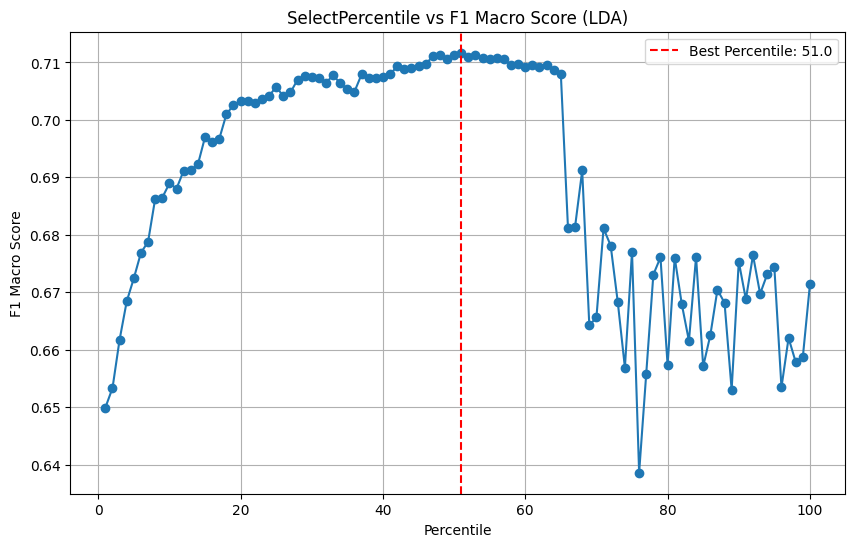

In [123]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.feature_selection import SelectPercentile
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from tqdm.notebook import tqdm
# import numpy as np
# import matplotlib.pyplot as plt

# # 평가 지표 및 교차 검증 설정
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# model = LinearDiscriminantAnalysis()

# # 결과 저장 리스트 초기화
# scores = []

# # SelectPercentile을 사용하여 최적의 percentile 찾기
# for percentile in tqdm(range(1, 101)):
#     # SelectPercentile 설정 및 피처 선택
#     sp = SelectPercentile(percentile=percentile)
#     x = sp.fit_transform(train_ft, target)

#     # 교차 검증을 통해 F1 Macro 점수 계산
#     score = cross_val_score(model, x, target, cv=cv, scoring="f1_macro", n_jobs=-1).mean()

#     # 결과 저장
#     scores.append([percentile, score])

# # numpy 배열로 변환
# scores = np.array(scores)

# # 최적의 percentile 찾기
# idx = np.argmax(scores[:, 1])
# best_percentile, best_score = scores[idx]
# print(f"최적의 Percentile: {best_percentile}, 최고 F1 Macro 점수: {best_score:.4f}")

# # 성능 변화 그래프 시각화
# plt.figure(figsize=(10, 6))
# plt.plot(scores[:, 0], scores[:, 1], marker='o')
# plt.axvline(x=best_percentile, color='r', linestyle='--', label=f'Best Percentile: {best_percentile}')
# plt.xlabel('Percentile')
# plt.ylabel('F1 Macro Score')
# plt.title('SelectPercentile vs F1 Macro Score (LDA)')
# plt.legend()
# plt.grid(True)
# plt.show()


In [148]:
# === 최적의 Percentile 값(51%) 적용 ===
sp = SelectPercentile(percentile=51)
train_ft_selected = sp.fit_transform(train_ft, target)

# === LDA 기본 모델 설정 ===
model = LinearDiscriminantAnalysis()

# === 교차 검증 설정 ===
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 교차 검증을 통한 F1 Macro 점수 평가 ===
scores = cross_val_score(model, train_ft_selected, target, cv=cv, scoring="f1_macro", n_jobs=-1)
print("LDA 기본 모델 평균 F1 Macro 점수:", scores.mean())

LDA 기본 모델 평균 F1 Macro 점수: 0.7116886836641182


### random tree

In [ ]:
# 평가 지표 및 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 랜덤 포레스트 하이퍼파라미터 검색 공간 설정
param_dist = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', None],
    'random_state': [42]
}

# 모델 정의
model = RandomForestClassifier()

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    verbose=2
)

# Random Search 수행
random_search.fit(train_ft, target)

# 최적의 하이퍼파라미터 출력
print("최적의 F1 Macro 점수:", random_search.best_score_)
print("최적의 하이퍼파라미터:", random_search.best_params_)

#최적의 F1 Macro 점수: 0.7115078079564034
# 최적의 하이퍼파라미터: {'random_state': 42, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'class_weight': 'balanced'}

In [57]:
model = RandomForestClassifier(
    random_state=42,
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='sqrt',
    max_depth=20,
    class_weight='balanced'
)

# 교차 검증을 통한 F1 Macro 점수 평가
scores = cross_val_score(model, train_ft, target, cv=cv, scoring="f1_macro")
print(f"교차 검증 F1 Macro 평균 점수: {scores.mean():.4f}")

교차 검증 F1 Macro 평균 점수: 0.7115


###  GradientBoostingClassifier

In [ ]:
model = GradientBoostingClassifier(random_state=42)  # 0.7056738084650951

scores = cross_val_score(model, train_ft, target, scoring="f1_macro")
scores.mean()

###  AdaBoostClassifier (시간날때 튜닝)

In [ ]:
# model = AdaBoostClassifier(random_state=42)  # 0.696761219639448

# scores = cross_val_score(model, train_ft, target, scoring="f1_macro")
# scores.mean()

In [ ]:
# # 평가 지표 및 교차 검증 설정
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # 하이퍼파라미터 검색 공간 설정
# param_dist = {
#     'n_estimators': [50, 100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'estimator': [
#         DecisionTreeClassifier(max_depth=1),
#         DecisionTreeClassifier(max_depth=2),
#         DecisionTreeClassifier(max_depth=3)
#     ],
#     'algorithm': ['SAMME', 'SAMME.R']
# }

# # AdaBoost 모델 정의 (base_estimator 대신 estimator 사용)
# model = AdaBoostClassifier(random_state=42)

# # RandomizedSearchCV 설정
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=20,
#     scoring='f1_macro',
#     cv=cv,
#     random_state=42,
#     verbose=2
# )

# # Random Search 수행
# random_search.fit(train_ft, target)

# # 최적의 하이퍼파라미터 출력
# print("최적의 F1 Macro 점수:", random_search.best_score_)
# print("최적의 하이퍼파라미터:", random_search.best_params_)

### MLPClassifier

In [ ]:
model = MLPClassifier(random_state=SEED)

scores = cross_val_score(model, train_ft, target, scoring="f1_macro")
scores.mean()

### catboost

In [ ]:
%pip install catboost
from catboost import CatBoostClassifier

In [ ]:
# 제거할 피처 목록
remove_features = [
    'A112000_브랜드코드수', 'A144000_브랜드코드수', 'A202000_브랜드코드수', 'A373000_브랜드코드수',
    '교복행사_구매비율', '단품_행사_캐릭터_구매', '훼미닌부틱_구매'
]

# train_ft와 test_ft에서 해당 피처 제거
train_ft_filtered = train_ft.drop(columns=remove_features, errors='ignore')
test_ft_filtered = test_ft.drop(columns=remove_features, errors='ignore')

model = CatBoostClassifier(class_weights=[1, 1.5], random_state=42, verbose=0)

# 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증을 통한 F1 Macro 점수 평가
scores = cross_val_score(model, train_ft_filtered, target, cv=cv, scoring='f1_macro', n_jobs=-1)
print(f"교차 검증 F1 Macro 평균 점수: {scores.mean():.4f}")

### lightgbm

In [ ]:

# 최적의 하이퍼파라미터
best_params = {
    'learning_rate':   0.09000000000000001,
    'num_leaves': 30,
    'feature_fraction':0.5,
    'bagging_fraction': 0.9,
    'min_data_in_leaf':50,
    'reg_alpha':  0.8888888888888888,
    'reg_lambda':  0.4444444444444444,
    'class_weight': 'balanced',
    'random_state': 42
}


# LightGBM 모델 초기화
model = LGBMClassifier(**best_params)

# Stratified K-Fold 설정
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# 교차 검증을 통한 F1 Macro 스코어 평가
scores = cross_val_score(model, train_ft, target, cv=cv, scoring='f1_macro', n_jobs=-1)
print(f"교차 검증 F1 Macro 스코어: {scores}")
print(f"평균 F1 Macro 스코어: {np.mean(scores):.4f}")

### xgboost

In [ ]:
# 클래스 비율을 기반으로 scale_pos_weight 설정 (XGBoost에서 클래스 불균형 조정)
scale_pos_weight = len(target[target == 0]) / len(target[target == 1])

# 최적의 하이퍼파라미터 (XGBoost에 맞게 조정)
best_params = {
    'learning_rate': 0.09000000000000001,
    'max_depth': 5,
    'n_estimators': 200,
    'subsample': 0.9,
    'colsample_bytree': 0.675,
    'reg_alpha': 1.5555555555555554,
    'reg_lambda': 1.1111111111111112,
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# XGBoost 모델 초기화
model = XGBClassifier(**best_params)

# Stratified K-Fold 설정
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# F1 Macro 스코어 설정
f1_macro = make_scorer(f1_score, average='macro')

# 교차 검증을 통한 F1 Macro 스코어 평가
scores = cross_val_score(model, train_ft, target, cv=cv, scoring=f1_macro, n_jobs=-1)
print(f"교차 검증 F1 Macro 스코어: {scores}")
print(f"평균 F1 Macro 스코어: {np.mean(scores):.4f}")

# 앙상블

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

### 배깅

In [ ]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# 평가 지표로 F1 Macro 스코어 설정
f1_macro = make_scorer(f1_score, average='macro')

# Stratified K-Fold 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 1. 개별 모델 정의 및 Bagging 적용 ===
# Logistic Regression 모델을 BaggingClassifier로 감싸기
lr_model = BaggingClassifier(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1.36, random_state=42, max_iter=500),
    n_estimators=10,
    random_state=42,
    n_jobs=-1
)

# CatBoostClassifier
cat_model = BaggingClassifier(
    estimator=CatBoostClassifier(class_weights=[1, 1.5], random_state=42, verbose=0),
    n_estimators=10, random_state=42, n_jobs=-1
)

# LightGBM
lgb_model = BaggingClassifier(
    estimator=LGBMClassifier(class_weight='balanced', random_state=42),
    n_estimators=10, random_state=42, n_jobs=-1
)

# XGBoost 모델의 class_weight 계산
scale_pos_weight = train_ft[target == 0].shape[0] / train_ft[target == 1].shape[0]
xgb_model = BaggingClassifier(
    estimator=XGBClassifier(
        learning_rate=0.09, max_depth=5, n_estimators=200,
        subsample=0.9, colsample_bytree=0.675,
        reg_alpha=1.5555, reg_lambda=1.1111,
        scale_pos_weight=scale_pos_weight,
        random_state=42, use_label_encoder=False, eval_metric='logloss'
    ),
    n_estimators=10, random_state=42, n_jobs=-1
)

# HistGradientBoostingClassifier
hist_model = BaggingClassifier(
    estimator=HistGradientBoostingClassifier(random_state=42),
    n_estimators=10, random_state=42, n_jobs=-1
)

# === 2. Bagging을 적용한 모델들을 VotingClassifier에 통합 ===
estimators = [
    ('lr', lr_model),
    ('cat', cat_model),
    ('lgb', lgb_model),
    ('xgb', xgb_model),
    ('hist', hist_model)
]

# 소프트 보팅 앙상블 모델 설정
soft_voting_model = VotingClassifier(
    estimators=estimators,
    voting='soft',
    n_jobs=-1
)

# === 3. 교차 검증을 통한 평가 ===
scores = cross_val_score(soft_voting_model, train_ft, target, cv=cv, scoring=f1_macro, n_jobs=-1)
print(f"Bagging 기반 VotingClassifier F1 Macro 평균 점수: {np.mean(scores):.4f}")


Bagging 기반 VotingClassifier F1 Macro 평균 점수: 0.7272


##### 모든조합

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import itertools

# 평가 지표로 F1 Macro 스코어 설정
f1_macro = make_scorer(f1_score, average='macro')

# Stratified K-Fold 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 개별 모델 정의 및 Bagging 적용 ===
lr_model = BaggingClassifier(
    estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1.36, random_state=42, max_iter=500),
    n_estimators=10, random_state=42, n_jobs=-1
)

cat_model = BaggingClassifier(
    estimator=CatBoostClassifier(class_weights=[1, 1.5], random_state=42, verbose=0),
    n_estimators=10, random_state=42, n_jobs=-1
)

lgb_model = BaggingClassifier(
    estimator=LGBMClassifier(class_weight='balanced', random_state=42),
    n_estimators=10, random_state=42, n_jobs=-1
)

scale_pos_weight = train_ft[target == 0].shape[0] / train_ft[target == 1].shape[0]
xgb_model = BaggingClassifier(
    estimator=XGBClassifier(
        learning_rate=0.09, max_depth=5, n_estimators=200,
        subsample=0.9, colsample_bytree=0.675,
        reg_alpha=1.5555, reg_lambda=1.1111,
        scale_pos_weight=scale_pos_weight,
        random_state=42, use_label_encoder=False, eval_metric='logloss'
    ),
    n_estimators=10, random_state=42, n_jobs=-1
)

hist_model = BaggingClassifier(
    estimator=HistGradientBoostingClassifier(random_state=42),
    n_estimators=10, random_state=42, n_jobs=-1
)

# 모델 리스트 정의
model_list = [
    ('lr', lr_model),
    ('cat', cat_model),
    ('lgb', lgb_model),
    ('xgb', xgb_model),
    ('hist', hist_model)
]

# 모든 모델 조합을 탐색하기 위해 itertools 사용
best_score = 0
best_combination = None

# 2개 이상의 모델 조합을 생성하여 테스트
for r in range(2, len(model_list) + 1):
    for combination in itertools.combinations(model_list, r):
        # 리스트 형태로 변환
        combination_list = list(combination)

        # Voting Classifier 설정 (부스팅 모델만 사용)
        soft_voting_model = VotingClassifier(
            estimators=combination_list,
            voting='soft',
            n_jobs=-1
        )

        # 교차 검증 수행
        try:
            scores = cross_val_score(soft_voting_model, train_ft, target, cv=cv, scoring=f1_macro, n_jobs=-1)
            avg_score = np.mean(scores)

            # 최적의 조합 및 점수 업데이트
            if avg_score > best_score:
                best_score = avg_score
                best_combination = combination_list

            print(f"모델 조합: {[name for name, _ in combination_list]}, F1 Macro 평균 점수: {avg_score:.4f}")
        except Exception as e:
            print(f"오류 발생: {e} (모델 조합: {[name for name, _ in combination_list]})")

# 최적의 모델 조합 출력
print("\n=== 최적의 모델 조합 ===")
print(f"모델 조합: {[name for name, _ in best_combination]}")
print(f"최고 F1 Macro 평균 점수: {best_score:.4f}")


##### 저장

In [ ]:
# 모델 학습 및 테스트 데이터 예측
soft_voting_model.fit(train_ft, target)
# preds = soft_voting_model.predict_proba(test_ft)[:, 1]

In [ ]:
# 2. 테스트 데이터 예측 (이진 예측값으로 반환)
preds = soft_voting_model.predict(test_ft)  # 이진 예측 사용

In [ ]:
test_ft = pd.read_csv(f"{DATA_PATH}test_ft2.csv")
# 3. ID 컬럼과 예측값을 DataFrame으로 변환
submission = pd.DataFrame({
    "ID": test_ft["ID"],  # 테스트 데이터에서 ID 컬럼 가져오기
    "target": preds       # 예측 확률값
})

# 4. CSV 파일로 저장 (index를 제외하고 저장)
submission.to_csv("bagging_.csv", index=False)

### 부스팅

# cv 점수 확인하기

In [ ]:
# from sklearn.model_selection import KFold, cross_val_score
# from lightgbm import LGBMClassifier

# cv = KFold(5, random_state=SEED, shuffle=True)
# model = LGBMClassifier(random_state=SEED)
# scores = cross_val_score(model, train_ft, target, cv=cv, n_jobs=-1, scoring="roc_auc")
# scores.mean()

# 모델 학습및 테스트 데이터 예측

In [ ]:
# model.fit(train_ft, target)

In [ ]:
# pred = model.predict_proba(test_ft)[:,1]
# pred.shape

# 예측 파일 저장후 컴피티션 페이지에 제출

In [ ]:
# pd.DataFrame(pred, columns=["target"]).to_csv("신혜빈.csv")

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.ensemble import VotingClassifier, BaggingClassifier, ExtraTreesClassifier
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.metrics import f1_score, make_scorer
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.naive_bayes import GaussianNB
# from lightgbm import LGBMClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.ensemble import HistGradientBoostingClassifier

# # 평가 지표로 F1 Macro 스코어 설정
# f1_macro = make_scorer(f1_score, average='macro')

# # Stratified K-Fold 설정
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # === 1. 개별 모델 정의 및 Bagging 적용 ===
# # Logistic Regression 모델을 BaggingClassifier로 감싸기
# lr_model = BaggingClassifier(
#     estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1.36, random_state=42, max_iter=500),
#     n_estimators=10,
#     random_state=42,
#     n_jobs=-1
# )

# # CatBoostClassifier
# cat_model = BaggingClassifier(
#     estimator=CatBoostClassifier(class_weights=[1, 1.5], random_state=42, verbose=0),
#     n_estimators=10, random_state=42, n_jobs=-1
# )

# # LightGBM
# lgb_model = BaggingClassifier(
#     estimator=LGBMClassifier(class_weight='balanced', random_state=42),
#     n_estimators=10, random_state=42, n_jobs=-1
# )

# # XGBoost 모델의 class_weight 계산
# scale_pos_weight = train_ft[target == 0].shape[0] / train_ft[target == 1].shape[0]
# xgb_model = BaggingClassifier(
#     estimator=XGBClassifier(
#         learning_rate=0.09, max_depth=5, n_estimators=200,
#         subsample=0.9, colsample_bytree=0.675,
#         reg_alpha=1.5555, reg_lambda=1.1111,
#         scale_pos_weight=scale_pos_weight,
#         random_state=42, use_label_encoder=False, eval_metric='logloss'
#     ),
#     n_estimators=10, random_state=42, n_jobs=-1
# )

# # HistGradientBoostingClassifier
# hist_model = BaggingClassifier(
#     estimator=HistGradientBoostingClassifier(random_state=42),
#     n_estimators=10, random_state=42, n_jobs=-1
# )


# # Naive Bayes
# nb_model = BaggingClassifier(
#     estimator=GaussianNB(),
#     n_estimators=10, random_state=42, n_jobs=-1
# )

# # Extra Trees Classifier
# extra_trees_model = BaggingClassifier(
#     estimator=ExtraTreesClassifier(n_estimators=100, random_state=42),
#     n_estimators=10, random_state=42, n_jobs=-1
# )

# # === 2. Bagging을 적용한 모델들을 VotingClassifier에 통합 ===
# estimators = [
#     ('lr', lr_model),
#     ('cat', cat_model),
#     ('lgb', lgb_model),
#     ('xgb', xgb_model),
#     ('hist', hist_model),
#     ('nb', nb_model),
#     ('extra_trees', extra_trees_model)
# ]

# # 소프트 보팅 앙상블 모델 설정
# soft_voting_model = VotingClassifier(
#     estimators=estimators,
#     voting='soft',
#     n_jobs=-1
# )

# # === 3. 교차 검증을 통한 평가 ===
# scores = cross_val_score(soft_voting_model, train_ft, target, cv=cv, scoring=f1_macro, n_jobs=-1)
# print(f"Bagging 기반 VotingClassifier F1 Macro 평균 점수: {np.mean(scores):.4f}")
